#### Task
create a bi-classifier using one labelled training data

#### Methodology
- Treating the project as an anamoly detection, using the training i'll be creating a boundary that'll help detect any novelty data points.
- After data import, i checked the columns for any null or empty values. Completely null columns were dropped from the dataset and missing values were filled in using the mode of that column. Using mode seemed the best way to go, instead of using a mean value.
- Decided to use Support Vector Machine (SVM) algorithim for one class classification as its best suited for this type of training data. That is, dataset that contains only one class and we need to detect whether a new data point is an outlier. 
- For this project, i'll be using sklearn library's OneSVM model to model and predict the results.
- The kernel used for this project was "rbf", i initially tried polynomial support vectors but accuracy was low for that
- Results were evalueated based on precision, recall and f1 score mainly. In anamoly detection problems, its easier to get a higher accuracy however precision and recall provide a better sense of how good the model is.

#### Possible Improvements
- Try using Principal Component Analysis to extarct main featuers and train the model using those features only
- With a bi-labeled dataset train a deep neural network to classify "0" and "1" cases. In this case we would need to use under or over sampling methods to improve the performance of the network.
- At the end of this notebook, i have provided a rough idea of how we can use the neural network using Keras. Please note i was only using the one label training data in the Neural Network for demonstration purposes.

### LIBRARIES USED

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, RMSprop

#nltk.download ()
np.random.seed(0)

Using TensorFlow backend.


### DATA UPLOAD

In [2]:
# Making a list of missing value types
missing_values = ["n/a", "na", "--"]

df_train = pd.read_csv("//Users//saad//Desktop//Neilsen//DatasetInterview-2019//trainingData.csv",na_values = missing_values)
df_test = pd.read_csv("//Users//saad//Desktop//Neilsen//DatasetInterview-2019//testingData.csv",na_values = missing_values)

df_train_row_count = df_train.shape[0]
df_test_row_count = df_test.shape[0]

print("df train count %d and df test count %d" %(df_train_row_count,df_test_row_count))

df train count 2833 and df test count 959


### DATA EXPLORATION - CHECKING FOR NA VALUES AND REPLACING THEM

In [3]:
#get all na column count -  this is to check which fields are null or which values are missing

def na_col_count (df_object):
    df = df_object.copy()
    col_names_list = list(df.columns.values)
    na_val_dict = {}

    for col in col_names_list:
        col_null_count = sum(df[col].isnull())
        if col_null_count > 0:
            na_val_dict[col] = col_null_count
    
    return na_val_dict


In [4]:
#find null values and fill them up - i'm using mode to replace null values

def find_replace_na (df_object,total_row_count):
    df = df_object.copy()
    col_names_list = list(df.columns.values)
    col_to_drop = []
    
    for col in col_names_list:
        col_null_count = sum(df[col].isnull())
        if col_null_count == total_row_count:
            col_to_drop.append(col)
            #df_train.drop(columns=[col])
        elif col_null_count > 0 and col_null_count < total_row_count:
            col_mode_val = stats.mode(df[col].values)
            df[col] = df[col].fillna(col_mode_val[0][0])

    df = df.drop(columns=col_to_drop)
    
    return df

#clean dataframe
df_train_clean = find_replace_na(df_train,df_train_row_count)
df_test_clean = find_replace_na(df_test,df_test_row_count)
#print(na_val_dict)

### REMOVE LABELLED COLUMN FROM DATASET TO CREATE A SEPARATE ARRAY FOR FEATUERS AND LABELS

In [5]:
#remove labelled column
train_clean_label = df_train_clean.C244.values
test_clean_label = df_test_clean.C244.values
df_train_clean_features = df_train_clean.drop(columns=["C244"])
df_test_clean_features = df_test_clean.drop(columns=["C244"])

### TRAIN AND PREDICT SVM MODEL

In [6]:
from sklearn import svm

clf = svm.OneClassSVM(nu=0.05, kernel="rbf",gamma=0.1,coef0 = 0.1) 
clf.fit(df_train_clean_features.values)

OneClassSVM(cache_size=200, coef0=0.1, degree=3, gamma=0.1, kernel='rbf',
            max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [7]:
#Predict model and replace -1 with 0 to math our test labels
pred_test = clf.predict(df_test_clean_features.values)
for ind,item in enumerate(pred_test):
    if item == -1:
        pred_test[ind] = 0

### EVALUATE SVM MODEL

In [8]:
tn, fp, fn, tp = confusion_matrix(test_clean_label, pred_test).ravel()
precision = tp / (tp+fp)
recall = tp / (tp + fn)
f1 = 2 * ((precision * recall) / (precision + recall))
print ("precision: %.2f  recall: %.2f  f1: %.2f" % (precision,recall,f1))
print("accuracy: %.2f" % accuracy_score(test_clean_label, pred_test))

precision: 0.90  recall: 0.92  f1: 0.91
accuracy: 0.87


### ROUGH WORK - ALTERNATIVE METHOD THAT COULD BE USED WITH 2 LABELLED DATA

In [103]:
# Build neural network
drop_outval = 0.2
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=df_train_clean_features.shape[1]))
#model.add(Dropout(0.5))
model.add(Dropout(drop_outval))
model.add(Dense(300, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dropout(drop_outval))
model.add(Dense(200, activation='relu'))
model.add(Dropout(drop_outval))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile neural network
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [104]:
# Fit the model
history = model.fit(df_train_clean_features.values, train_clean_label, epochs=100, batch_size=10, validation_data=(df_test_clean_features.values, test_clean_label))



Train on 2833 samples, validate on 959 samples
Epoch 1/100
2833/2833 [==============================] - 2s 739us/step - loss: 0.0237 - acc: 0.9996 - val_loss: 1.7393 - val_acc: 0.7153
Epoch 2/100
2833/2833 [==============================] - 1s 437us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 2.0054 - val_acc: 0.7153
Epoch 3/100
2833/2833 [==============================] - 1s 441us/step - loss: 5.7100e-04 - acc: 1.0000 - val_loss: 2.1623 - val_acc: 0.7153
Epoch 4/100
2833/2833 [==============================] - 1s 438us/step - loss: 3.8690e-04 - acc: 1.0000 - val_loss: 2.2763 - val_acc: 0.7153
Epoch 5/100
2833/2833 [==============================] - 1s 441us/step - loss: 2.7395e-04 - acc: 1.0000 - val_loss: 2.3612 - val_acc: 0.7153
Epoch 6/100
2833/2833 [==============================] - 1s 440us/step - loss: 2.0811e-04 - acc: 1.0000 - val_loss: 2.4297 - val_acc: 0.7153
Epoch 7/100
2833/2833 [==============================] - 1s 444us/step - loss: 1.9329e-04 - acc: 1.0000 - val_loss:

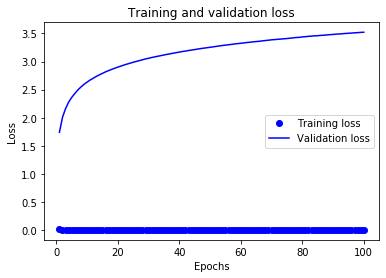

In [105]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

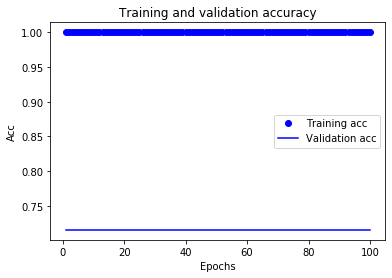

In [106]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [110]:
pred = model.predict(df_test_clean_features.values)
pred = np.round(pred*100,decimals=0)
pred = np.where(pred >= 70, 1, 0)

accuracy_score(test_clean_label, pred)

0.7153284671532847

In [111]:
#test_clean_label

In [114]:
predictions = clf.predict(df_test_clean_features.values)
accuracy_score(test_clean_label, predictions)

0.7153284671532847